# Avsluttende programmeringsprosjekt ProgMod
## Problemstillingene
* Hvordan kan vi bruke programmering til å modellere og simulere kunstig intelligens? 
* Hvilke faktorer påvirker læring, beslutningstaking og etikk? 
* Hvilke begrensninger har modellene dine, og drøft hva de forteller oss om kunstig intelligens?

# Innhold
1. Introduksjon
    - Definisjon og kort beskrivelse av maskinnlæring
2. Eksempler på maskinlæring
    - Forskjellig modeller sammenliknet for forskjllig treningsandeler
3. Resultater
    - En objektiv analyse av resultatene
4. Drøfting
    - Drøfting av resultatene
5. Maskinlæring i samfunnet
    - Drøfting rundt bruken av maskinlæring i samfunnet generelt
6. Konklusjon
    - Oppsumering av alle delene

# 1. Introduksjon til maskin læring
Ordboken til Oxford definerer kunstig intelligens som “utviklingen av datasystemer i stand til å utføre oppgaver som normalt krever menneskelig intelligens, for eksempel visuell persepsjon, talegjenkjenning, beslutningstaking og oversettelse mellom språk”. Men flere av disse vanlige algoritmene og programmene klarer også å utføre disse oppgavene. Så hva er det som skiller kunstig intelligens fra vanlige datasystemer? Den store forskjellen mellom kunstig intelligens og vanlige programmer er at i vanlig programmering må vi finne mønstrene selv og programmere et system som bruker mønsteret. Med kunstig intelligens skjer utviklingen på en grunnleggende annen måte. Istedenfor å fortelle programmet nøyaktig hva det skal gjøre, gir vi det et datasett, og programmet finner mønstre selv. Ofte kan dette være mer effektivt enn den “gamle måten”, men det kan også ha ulemper, for eksempel ved å finne mønstre som ikke er relevante. Det kan også være partisk hvis datasettet ikke er representativt, og mønstrene AIen finner er derfor ikke representative. Et eksempel på dette er Amazons AI som hjalp dem med ansettelse. Den var partisk fordi den var basert på tidligere CV-er de hadde mottatt som da var mannsdominerte. Programmet anbefalte derfor menn oftere enn kvinner.<sup>[1]</sup> Kunstig intelligens er ikke en perfekt løsning på alt, og man må være klar over hvordan man bruker det på en ansvarlig måte. Men det betyr ikke at det ikke kan være nyttig hvis man forstår begrensningene og bygger rundt dem.



# 2. Eksempler på maskinlæring
Under har jeg flere kodeeksempler. De bruker alle hver sin modell og måte å forutse data. De blir evaluert på nøyaktigheten sin avhengig av hvor høy treningsandelen er. Programmet kjører også hver modell flere ganger for å prøve å motvirke uteliggere der modellen fremstår bedre eller dårligere enn det den er til vanlig. Alle modellene trenes på et datasett om pingviner og skal prøve å bestemme arten til pingvinen basert på data om pingvinen. Det er beskrivelser av forskjellene på hver modell underveis. På slutten er resultatene fremstilt grafisk.

In [10]:
# Import/define

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import neighbors, tree, ensemble, linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras import layers


def map_string_to_number(s):
    # Define your custom mapping from strings to numbers here
    if s == 'Adelie' or s == 'MALE' or s == 'tree':
        return float(0)
    elif s == 'Chinstrap' or s == 'FEMALE' or s == 'RandomForestClassifier':
        return float(1)
    elif s == 'Gentoo' or s == 'LogisticRegression':
        return float(2)
    elif s == 'KNeighborsClassifier':
        return float(3)
    elif s == 'SVC':
        return float(4)
    elif s == 'NN':
        return float(5)
    elif type(s) == 'float':
        return s
    else:
        return 100
    
titles = {'model':[], 'treningsandel': [], 'accuracy': []}
model_eval = pd.DataFrame(titles)

test_amount = 40
test_amoun_nn = 10

### Decision Tree
En DecisionTreeClassifier er en modell der interne noder representerer egenskapene til et datasett. Det bruker da enkle regler for å følge ned det treet til den ender opp med et resultat. Det er en modell som er veldig enkelt å forstå og tolke. Man kan lett visualisere strukturen og logikken modellen bruker. 

In [11]:
# tree.DecisionTreeClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(10, 90):
    accuracy_list = []
    trainingsize_eval = i/100
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]
        
        model = tree.DecisionTreeClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)

        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
        
    # Takes the average of 10 runs and adds it to the data frame for eval   
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['tree'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### RandomForestClassifier
En RandomForestClassifier er basert på valg-trær. Den tilpasser deler av dataen til forksjellige trær og kombinerer de til et gjennomsnitt. Dette forbedrer nøyaktigheten og prøver å kontrollere overtilpasning. Modellen er mye i bruk i både regresjon og klassifiserings problemer.

In [12]:
# RandomForestClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(10, 90, 2):
    accuracy_list = []
    trainingsize_eval = i/100
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = RandomForestClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
        
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['RandomForestClassifier'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


## LogisticRegression
Logistisk regresjon er en statistisk metode som brukes for å passe en regressjonsmodell når responsvariabelen er binær. Den er mye brukt i statistisk  analyse ettersom den ofte er stabil.

In [13]:
# LogisticRegression

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(10, 90):
    accuracy_list = []
    trainingsize_eval = i/100
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]
        
        model = LogisticRegression(max_iter=2000)  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
       
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval    
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['LogisticRegression'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


## KNeighborsClassifier
KNeighborsClassifier er en modell som er basert på at du gir den en K-verdi og så ser den på nabo-punktene til den K-verdien og ut ifra det bestemmer en respons. Den er enkel å implementere og trenger ikke å trenes på alle datapunktene. 

In [14]:
# KNeighborsClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(10, 90):
    accuracy_list = []
    trainingsize_eval = i/100
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = KNeighborsClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
        
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)

    # Takes the average of 10 runs and adds it to the data frame for eval        
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['KNeighborsClassifier'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


## SVC
SVC står for C-Support Vector Classification. Det er en type SVM som blir brukt i klassifikasjon. 

In [15]:
# SVC

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(10, 90):
    accuracy_list = []
    trainingsize_eval = i/100

    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = SVC()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)

        precision = precision_score(testkategorier, predictions, average='macro', zero_division=1)
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['SVC'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


## Nevralt Nett
Dette nevrale nettet fungerer ved å ta input data om pingvinen og sender det gjennom lag av nettverket. I hvert lag blir dataen transformert til forskjellig vektet koblinger mellom "nevroner" og en aktiveringsfunksjon. Det første laget bruken en sigmoid funksjon som tar inputen og moser den til en verdi mellom 0 og 1. Det andre laget bruker en lineær aktiveringsfunksjon, som betyr at resultatene til laget er en vektlagt sum av inputene. Modellen er trenet på et datasett ved å justere vektleggingen på koblingene mellom nevronene for å minimere `mean squared error` mellom den spådde arten og den faktiske arten. Dette gjøres ved å bruke en optimaliseringsalgoritme som heter Adam. Når modellen er trenet kan den brukes til å spå nye data gjennom lagene og kalkulere resultatene fra det siste laget. Noen fordeler med å bruke nevrale nett er evnen til å lære komplekse sammenhenger mellom dataen og resultatene. I tillegg har den evnen til å generalisere nye data og kan derfor spå ganske nøyaktig ny data. Noen av ulempene med nevrale nett er at det kan være vannskelig å tolke resultatene siden det måten den kommer frem til resultatet kan fort bli vanskelig  å forstå. Det er også beregningsmessig dyrt å trene nevrale nett, spesielt på store datasett.

### Prossesen å lage en modell
Jeg har forsøkt å endre hyperparametere for å stille inn modellen så den kunne bli så bra som mulig. Under ser du et tidligere forsøk som gir dårligere resultater enn den endelige modellen. Dette er grunnet flere ting, men noen av de største forskjellene er at det er færre lag i den endelige modellen. Grunnen til at flere lag gjør modellen dårligere i dette tilfellet er at den overtilpasser dataen og blir derfor sensitiv til støy i datasettet og klarer ikke å generalisere nokk på ny data. Det er også flere egenskaper den trener på enn i den endelige modellen. Grunnen til at jeg valgte ut noen få egenskaper å trene på er at det hjelper med å redusere støy og det hjelper modellen å være mer nøyaktig i dette tilfellet.

In [16]:
# Nevral Nett flere lag

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

pingvindata['species'] = pingvindata['species'].map(map_string_to_number)
pingvindata['sex'] = pingvindata['sex'].map(map_string_to_number)

total_iterations = 160

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']

# Adds a progressbar
with tqdm(total=total_iterations, desc="Training") as pbar:
    # A loop for testing different training sizes
    for i in range(10, 90, 5):
        accuracy_list = []
        trainingsize_eval = i/100
        
        # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
        for j in range(test_amoun_nn):
            model = tf.keras.Sequential()
            model.add(layers.Dense(10, activation="sigmoid", input_shape=(4,)))
            model.add(layers.Dense(10, activation="sigmoid"))
            model.add(layers.Dense(10, activation="sigmoid"))

            model.add(layers.Dense(1, activation="linear"))
        
            
            model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
                loss='mean_squared_error',
                metrics=['accuracy']) 
            
            
            ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)
            x = ml_data[0]
            X_test = ml_data[1]
            y = ml_data[2]
            y_test = ml_data[3]            

            model.fit(x, y, epochs=150, verbose=0)

            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

            accuracy_list.append(accuracy)
            
            pbar.update(1)

        # Takes the average of 10 runs and adds it to the data frame for eval
        accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
        data = pd.DataFrame({'model':['NN mange lag'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
        model_eval = pd.concat([model_eval, data], ignore_index=True)


Training: 100%|██████████| 160/160 [04:19<00:00,  1.62s/it]


### Endelig modell
Under er den endelige modellen etter hyperparametere tilpasningen. Den har høyere nøyaktighet og er i tillegg raskere enn den andre modellen.

In [17]:
# Nevral Nett Endelig

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

pingvindata['species'] = pingvindata['species'].map(map_string_to_number)
pingvindata['sex'] = pingvindata['sex'].map(map_string_to_number)

total_iterations = 160

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm',]] # features  
categories = pingvindata['species']

# Adds a progressbar
with tqdm(total=total_iterations, desc="Training") as pbar:
    # A loop for testing different training sizes
    for i in range(10, 90, 5):
        accuracy_list = []
        trainingsize_eval = i/100
        
        # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
        for j in range(test_amoun_nn):
            model = tf.keras.Sequential()
            model.add(layers.Dense(10, activation="sigmoid", input_shape=(2,)))
            #model.add(layers.Dense(8, activation="sigmoid"))
            model.add(layers.Dense(1, activation="linear"))
                        
            model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
                loss='mean_squared_error',
                metrics=['accuracy']) 
            
            
            ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)
            x = ml_data[0]
            X_test = ml_data[1]
            y = ml_data[2]
            y_test = ml_data[3]            

            model.fit(x, y, epochs=150, verbose=0)

            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            
            accuracy_list.append(accuracy)
            
            pbar.update(1)

        # Takes the average of 10 runs and adds it to the data frame for eval
        accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
        data = pd.DataFrame({'model':['NN'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
        model_eval = pd.concat([model_eval, data], ignore_index=True)


Training: 100%|██████████| 160/160 [03:30<00:00,  1.32s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


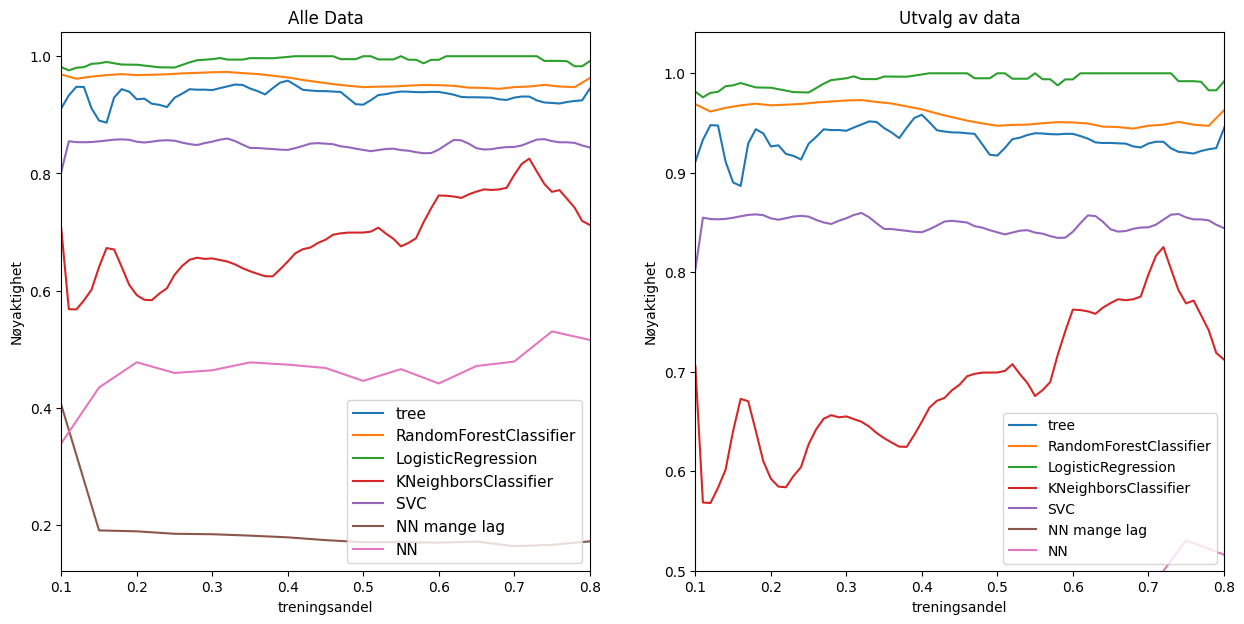

In [18]:
# Modell evaluering
from scipy.signal import savgol_filter    

model_eval_plot = model_eval.copy()
model_eval_plot["accuracy"] = model_eval_plot[["accuracy"]].apply(savgol_filter,  window_length=3, polyorder=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Makes a plot with all the data
sns.lineplot(data=model_eval_plot, x='treningsandel', y='accuracy', hue='model', ax=ax1)
ax1.set_title('Alle Data')
ax1.set_ylabel('Nøyaktighet')
plt.legend(fontsize=8)
ax1.set_xlim(0.1,0.8)

# Makes plot with exerpt of data
sns.lineplot(data=model_eval_plot, x='treningsandel', y='accuracy', hue='model', ax=ax2)
ax2.set_title("Utvalg av data")
ax2.set_ylabel('Nøyaktighet')
ax2.set_ylim(0.5)

ax2.legend(fontsize=10)
ax1.legend(fontsize=11)
ax2.set_xlim(0.1,0.8)


# Show the plot
plt.show()

# 3. Resultater
Over kan du se resultatene i et punkt plot. Det viser nøyaktigheten som en funksjon av treningsandelen. <br>
Logistisk regresjon ligger øverst og ganske stabil uansett treningsandel. Den treffer en perfekt score før slutten og holder seg stabil derfra. <br>
RandomForestClassifier ligger under og varier litt mer enn logistisk regresjon. Den trender ned fra starten før den hopper opp til perfekt score når treningsandelen er høy. <br>
Tree er under det igjen. Den har større variasjoner, men følger RandomForestClassifier løst. Den oppnår også en perfekt score når treningsandelen er høy. <br>
SVC er under tree, men er ganske stabil. Den trender litt ned mot slutten. <br>
KNeighboursClassifier starter ganske lavt på 0.6, men trender oppover mot 0.8 frem til treningsandelen er ca. 0.7. Forbi 0.7 går nøyaktigheten raskt ned og modellen er mer ustabil. <br>
Den beste nevral nett modellen starter veldig lavt på 0.5, men trender oppover til 0.7. Den har mye variasjon på veien. <br>
Den første nevrale nett modellen har klart dårligst nøyaktighet. Den starter med å stupe ned fra 0.4 til 0.2 og trender videre nedover sakte.

# 4. Drøfting
Det er ofte nevrale nettverk man tenker på når man snakker om maskinlæring og kunstig inteligen selv om det er maskinlæring inneholder mye annet også. <br>

Når det gjelder nøyaktigheten til modellene, så er det flere faktorer som spiller inn. En av de viktigste faktorene er kvaliteten på datasettet som brukes til å trene modellen. Hvis datasettet er for lite eller ikke representerer virkeligheten godt nok, vil modellen ikke være nøyaktig. En annen faktor er antall variabler som brukes i modellen. Hvis det er for få variabler, vil modellen ikke være i stand til å fange opp alle sammenhenger i dataene. På den andre siden, hvis det er for mange variabler, kan modellen bli overtilpasset og dermed miste evnen til å generalisere til nye data. Datasettet som brukes i dette eksempelet kan være for lite og gjør derfor at ikke alle modellene oppnår potensialet sitt.

Logistisk regresjon, den grønne linjen, er veldig stabil uansett treningsandelen. Den har en mindre tendens til å overtilpasse dataen og er bra med lineære data. Dette stemmer med resultatene jeg har samlet inn. Det er også noen ulemper ved den logistiske regresjonen som ikke har vært relevant i dette datasettet, men kan vise seg i andre situasjoner. Hvis mengden observasjoner er mindre en mengde responsvariabler burde man ikke bruke logistisk regresjon fordi den da har en tendens til å overtilpasse. Den største ulempen med logistisk regresjon er at det er antatt en linearitet mellom variablene man gir den og resultatene man får tilbake. Det er denne modellen som var mest nøyaktig for dette datasettet og er derfor den mest anvendelige om man skulle brukt det til noe praktisk som pingvin klassifikasjon.

RandomForestClassifier, den oransje linjen, starter litt under logistisk regresjon, og trender nedover fra starten. Dette kan indikere at den overtilpasser til dataen. Når man bruker en RandomForestClassifier får man flere av fordelene fra valg-tre, som at den håndterer manglende data. Noen ulemper også. En av de største utfordringene er det samme som valg-tre, og det er å finne riktig bredde og dybde på treet. Dette kan være årsaken til at den overtilpasser. RandomForestClassifier brukes i bla. bankindustrien for å oppdage kredittkortsvindel og forutsi lånefeil ettsom det er en modell som er ganske transparent.

Beslutningstre modellen, den blå linjen, scorer litt dårligere enn RandomForestClassifier modellen, men den er mer stabil. Det er logisk ettersom RandomForestClassifier er basert på samme teknikk som valg-tre modellen, men med forbedringer. Noen fordeler med valg-tre modellen er at den håndterer uteliggere og manglende verdier bra. Den fungerer bra på både små og store datasett. Det finnes derimot også noen ulemper. En av hovedutfordringene er å finne den optimale dybden og bredden på treet. Hvis det er for lite kan det overse viktige mønster. Hvis treet er for stort kan det overkorrigere og være sensitiv til støy. Et valg-tre er også sensitiv til endringer i treningsdataen og kan ende opp med inkonsekvente trær. Beslutningstre er ekstremt nyttige for dataanalyse og maskinlæring fordi de bryter ned komplekse data i mer håndterbare deler. De brukes ofte i disse feltene for prediksjonsanalyse, dataklassifisering og regresjon.

SVC, den lilla linjen, presterer dårligere enn valg-tre modellen og trender nedover. Den er litt ustabil. Dette kan indikere at den er overtilpasset og er for sensitiv. SVC presterer best når det er mangedimensjonaldata, som det ikke er i dette tilfellet. Den kan være svært nøyaktig om man velger riktig kjerne til situasjonen. En stor ulempe med SVC er at tiden det tar å passe modellene øker eksponentielt med mengden data man gir den og SVC er derfor upraktisk med for store datasett. SVC er en populær maskinlæringsalgoritme på grunn av sin høye effektivitet i høye dimensjonale rom og minneeffektivitet. SVC kan brukes i tekstbaserte applikasjoner for å klassifisere håndskriften til to forskjellige personer.

KNabo-klassifisering, den røde linjen, er mer ustabil enn de andre og presterer dårlig med lite data. Den treffer også et punkt der den begynner å gå nedover igjen. Dette kan indikere at den har for lite treningsdata til å begynne med, men den blir etterhvert overtilpasset. KNabo-klassifisering har noen fordeler som at den veldig lite prosessering før evalueringen som er praktisk i dette eksempelet ettersom modellen må kjøres mange ganger. Noen av ulempene med klassifiserings metoden er at den optimale verdien til K avhenger sterkt av dataen din. Om k verdien er veldig høy eller lav vil den kunne ta med klassifiseringer som ikke er relevante. KNN har mange praktiske bruksområder i ulike felt. For eksempel kan det brukes i finans for å forutsi aksjemarkedet, valutakursen, bankkonkurser, osv.

Den endelige nevrale nett modellen, den rosa linjen, starter med veldig lav nøyaktighet, men den trender mye oppover og platåer aldri. Dette kan være en indikasjon på at om man hadde hatt mer data hadde modellen fungert bedre. Nevrale nettverk har vist seg å være spesielt effektive i mange anvendelser av maskinlæring. Dette skyldes at de kan lære komplekse sammenhenger mellom variabler og dermed gi høy nøyaktighet i prediksjonene. Grunnen til at nevrale nett ikke er så effektive på dette datasettet kan være at det er for lite og det er derfor ikke nok data å trenes på. Sammenhengene i dette datasettet er også ganske lineære og det gjør at nevrale nett, som presterer bedre på komplekse sammenhenger, ikke fungerer så bra i denne situasjonen.

Den første nevrale nett modellen, den brune linjen, scoret klart verst blant disse modellene. Dette kan skyldes at den er veldig overtilpasset ettersom den har både for mange lag og den hadde for mange input variabler. Begge disse kan være årsaker til overtilpasning og er tilstede. En annen indikasjon til at den er overtilpasset er det at den stuper fra 0.4 til 0.2 med en gang. Dette viser at med mindre treningsdata presterer den bedre.

En interessant ting å observere er hvordan modellene håndterer å ha lite treningsdata. Noen av modellene, som logistisk regresjon, fungerer bra stort sett uansett hvor mye trenings data den har. SVC presterer litt dårligere, men den er stabil uansett mengden data. KNabo klassifisering er mer ustabilt og for å få en god modell er det veldig viktig å har riktig mengde data. RandomForestClassifier som blir dårligere med for mye data viser tydelig at det ikke alltid er bedre med mer data.

En feilkilde kan være at optimalisering av modellen er en viktig faktor for å oppnå høy nøyaktighet. Dette innebærer å finne de beste parameterne for modellen og justere dem slik at modellen gir best mulig resultat. Selv om jeg har gjort mitt beste for å optimalisere modellene, er det mulig at noen med mer erfaring ville ha oppnådd bedre resultater. Det kan være kombinasjoner av parametere som jeg ikke har tenkt å prøve som kunne gitt bedre resultater, men som noen som har holdt på med det lengre ville sett. Det kan også være at de hadde valgt andre modeller selv om jeg har prøvd å finne relevante modeller å teste. 

# 5. Maskinlæring i samfunnet
Maskinlæring og kunstig intelligens (KI) har blitt stadig mer utbredt i dagens samfunn og har mange bruksområder, som chat-modeller. Chat-modeller den typen KI flest folk er kjent med og den brukes i systemer som ChatGPT og Bing Chat. De presterer så bra at mange blir lurt til å tro at det er et menneske. Disse modellene kan brukes til å f.eks. automatisere kundeservice og gi raskere svar på spørsmål fra kunder.

Det er imidlertid også bekymringer knyttet til bruken av KI i chat-modeller og andre applikasjoner. For eksempel kan KI-systemer være sårbare for angrep og manipulasjon, og det kan være vanskelig å avgjøre om en samtale skjer mellom et menneske eller en maskin. Det er også bekymringer knyttet til personvern og sikkerhet når det gjelder innsamling og bruk av data i KI-systemer.

Når det gjelder ChatGPT, er dette en modell som ble utviklet av OpenAI for å simulere samtaler mellom mennesker og maskiner. Selv om ChatGPT har gjort det mulig for den gjennomsnittlige forbrukeren å bruke AI i det daglige livet sitt, har det også vært noen utfordringer med modellen. For eksempel var GPT-3-modellen som ChatGPT var basert på, trent på eldre data og var optimalisert for samtaleflyt og ikke nøyaktighet. Dette førte til at modellen slet med matematikk og fant opp fakta for å beholde samtale flyten. Microsoft integrerte senere OpenAI sin GPT-3-modell i Bing for å gi brukerne bedre søkemotorer og anbefalingssystemer. Problemet med disse chat-modellene, spesielt GPT-3 baserte modeller, er at de er veldig selvsikre uansett om de har rett eller har kilder i det hele tatt.

En bekymring som har kommet frem etter at chat-modeller ble populære er at forbrukere kan ha urealistiske forventninger til hva KI kan gjøre. For eksempel kan et utvalg av forbrukere tro at KI-systemer kan løse alle problemer eller gi nøyaktige svar på alle spørsmål. Dette kan føre til at forbrukere tar beslutninger basert på feilaktig informasjon eller at de blir skuffet når KI-systemer ikke fungerer som forventet. Chat-modeller er ofte veldig selvsikre selv når de har feil, noe som kan føre til at forbrukere blir villedet. Det har allerede vært hendelser der en KI har overbevist noen om å ta selvmord. Dette viser hvor viktig det er at alle forstår begrensningene til KI. Et eksempel på noen som ikke forstår begrensningene til KI var Amazon som jeg nevnte i innledningen.

Selv om det er bekymringer knyttet til bruken av KI og maskinlæring, har teknologien også mange fordeler. For eksempel kan KI-systemer brukes til å automatisere oppgaver som tidligere var manuelle eller som krevde mye tid og ressurser. Dette kan frigjøre tid og ressurser som kan brukes til andre formål. Dette kan skape store verdier for bedrifter som kan trenge mindre ansatte som gjør relativt enkle oppgaver. KI-systemer kan også brukes til å forbedre nøyaktigheten og effektiviteten til mange prosesser. For eksempel kan KI-systemer brukes til å forutsi etterspørselen etter produkter eller tjenester, noe som kan hjelpe bedrifter med å planlegge produksjon og lagerbeholdning. KI-systemer kan også brukes til å analysere store mengder data og finne mønstre og sammenhenger som ellers ville vært vanskelige å oppdage.

Det er imidlertid viktig å huske at KI-systemer ikke alltid er den beste løsningen. I noen situasjoner kan det være bedre å bruke manuelle eller tradisjonelle metoder. For eksempel kan manuelle metoder være bedre egnet til situasjoner der det er viktig å ta hensyn til etiske eller moralske spørsmål eller der det er viktig å forstå hvordan beslutninger blir tatt.

# 6. Konklusjon 
Nøyaktigheten til modellene avhenger av flere faktorer, inkludert kvaliteten på datasettet og antall variabler som brukes i modellen. Noen av de presterte bedre uansett treningsandel, som logistisk regresjon. Andre presterte dårligere, men forbedret seg ettersom treningsandelen ble større, f.eks. KNN. Nevrale nett presterte dårlig i dette eksempelet, men nøyaktigheten trendet opp helt til slutten, som kan indikere at om den hadde hatt mer data så kunne den prestert bedre. Enklere modeller som logistisk regresjon er bedre egnet enn nevrale nett til dette brukstilfellet.

Hvordan modellene håndterer å ha lite treningsdata varierer. Logistisk regresjon fungerer bra stort sett uansett hvor mye trenings data den har. SVC presterer litt dårligere, men den er stabil uansett mengden data. KNabo klassifisering er mer ustabilt og for å få en god modell er det veldig viktig å ha riktig mengde data. En feilkilde kan være at optimalisering av modellen er en viktig faktor for å oppnå høy nøyaktighet og at en med lite erfaring som meg ikke har klart å optimalisere modellen riktig.

Maskinlæring og kunstig intelligens (KI) har blitt stadig mer utbredt i dagens samfunn og har mange bruksområder, som chat-modeller. Det er imidlertid bekymringer knyttet til bruken av KI i chat-modeller og andre applikasjoner. Chat-modellene i bruk i dag samler inn sinnssyke mengder data og personvern er derfor en stor bekymring. Det er også bekymringer knyttet at kan være vanskelig for folk å vurdere om de snakker til et menneske eller KI.

En bekymring som har kommet frem etter at chat-modeller ble populære er at forbrukere kan ha urealistiske forventninger til hva KI kan gjøre. Dette kan føre til at forbrukere tar beslutninger basert på feilaktig informasjon.
Selv om det er bekymringer knyttet til bruken av KI og maskinlæring, har teknologien også mange fordeler. For eksempel kan KI-systemer brukes til å automatisere oppgaver som tidligere var manuelle eller som krevde mye tid og ressurser. Dette kan frigjøre tid og ressurser som kan brukes til andre formål. KI-systemer kan også brukes til å forbedre nøyaktigheten og effektiviteten til mange prosesser.

Det er imidlertid viktig å huske at KI-systemer ikke alltid er den beste løsningen. I noen situasjoner kan det være bedre å bruke manuelle eller tradisjonelle metoder.

## Kilder
https://www.aftenposten.no/amagasinet/i/8JX2V1/ki-forsker-inga-strumke-jeg-tror-ikke-vi-innser-hvor-stor-paavirkning-kunstig-intelligens-vil-faa